# Import

In [1]:
import pandas as pd
import os
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
from utils.Perspectiver import Perspectiver
from utils.Loader import CardsDataset
from arquitecture.CardsClassifier import CardClassifier
from arquitecture.SupraCardClassifier import SupraCardClassifier

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently using", DEVICE)

Currently using cuda


# Dataset scale testing

In [8]:
CardsDataset().data.head()

,class index,filepaths,labels,suit,category,filepaths_full
0,9,train/five of diamonds/005.jpg,five of diamonds,diamonds,five,data/train/five of diamonds/005.jpg
1,44,train/ten of spades/015.jpg,ten of spades,spades,ten,data/train/ten of spades/015.jpg
2,11,train/five of spades/104.jpg,five of spades,spades,five,data/train/five of spades/104.jpg
3,9,train/five of diamonds/028.jpg,five of diamonds,diamonds,five,data/train/five of diamonds/028.jpg
4,27,train/nine of hearts/037.jpg,nine of hearts,hearts,nine,data/train/nine of hearts/037.jpg


In [9]:
scale_1 = 1
scale_2 = 0.60
dataset_scale_100 = CardsDataset(scale=scale_1)
dataset_scale_050 = CardsDataset(scale=scale_2)

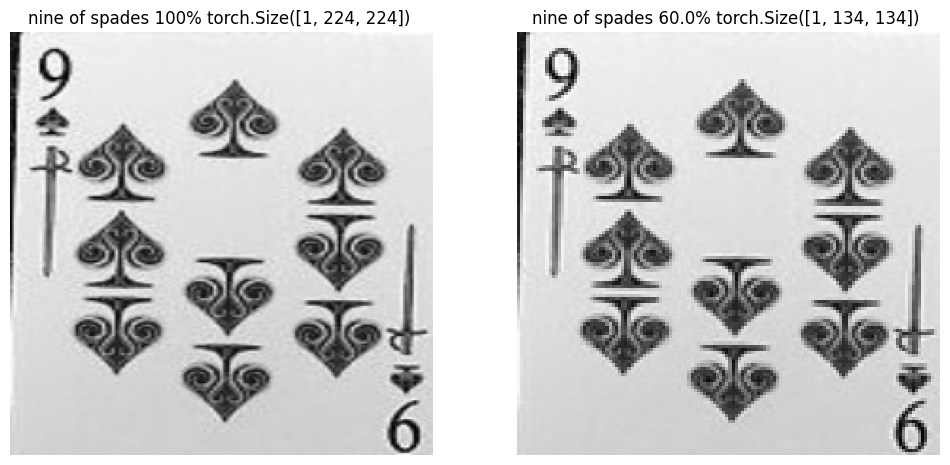

In [10]:
import random
idx = random.randint(0, len(dataset_scale_050))
img_1 , label_1 = dataset_scale_100.__getitem__(idx)
img_2 , label_2 = dataset_scale_050.__getitem__(idx)
Perspectiver.plotComparison(imageBefore = Perspectiver.grayscale_to_rgb(img_1.numpy()[0]) , 
                            imageAfter = Perspectiver.grayscale_to_rgb(img_2.numpy()[0]) , 
                            titleBefore = f"{dataset_scale_100.decode_label(label_1)} {scale_1*100}% {img_1.size()} ",
                            titleAfter = f"{dataset_scale_050.decode_label(label_2)} {scale_2*100}% {img_2.size()} "
                            )

# Training process

## Hyperparameters

In [2]:
EPOCH = 100
BATCH_SIZE = 500
NUN_WORKERS = 8
LR = 0.003
SEED = 555

In [3]:
def set_torch_seed(seed: int = 555):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_torch_seed(SEED)

In [4]:
def save_checkpoint(model, epoch, optimizer, loss, name):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f"models/checkpoints/{name}.pth")

def validation(model, valid_loader, criterion, device):
        valid_loss = 0.0
        correct = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs.to(device))
                loss = criterion(outputs, torch.argmax(labels.to(device), dim=1))
                valid_loss += loss.item() * inputs.size(0)
                
                x, preds = torch.max(outputs, dim=1)
                correct += (preds == torch.argmax(labels.to(device), dim=1)).sum().item()
        
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_prec = correct / len(valid_loader.dataset)

        return valid_loss, valid_prec
    
def training(model, optimizer, criterion, train_loader, valid_loader, name, device, epochs):
    max_prec = 0
    train_loss_record = []
    valid_loss_record = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, torch.argmax(labels.to(device), dim=1))
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        model.eval()
        
        valid_loss, valid_prec = validation(model, valid_loader, criterion, device)
        if valid_prec > max_prec:
            save_checkpoint(model, epoch, optimizer, loss, name)
            max_prec = valid_prec
        
        train_loss_record.append(train_loss)
        valid_loss_record.append(valid_loss)
        print(f"EPOCH {epoch+1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {valid_loss:.4f} - Validation Precision: {valid_prec:.4f}")
        
    return train_loss_record, valid_loss_record

# Suit

In [ ]:
csv_file = "cards.csv"
target = "suit"

train_dataset = CardsDataset(scale=0.6, split="train", csv_file=csv_file, target=target)
test_dataset = CardsDataset(scale=0.6, split="test", csv_file=csv_file, target=target)
valid_dataset = CardsDataset(scale=0.6, split="valid", csv_file=csv_file, target=target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)

_, label = test_dataset.__getitem__(1)

classifier = CardClassifier(image_size=torch.Size((134, 134)), 
                            convolution_structure=[1,8,8,16,16,24,24,32,32],
                            expert_output_len=3,
                            expert_depth=4,
                            output_len=len(label),
                            pool_depth=2
                            ).to(DEVICE)


print(classifier.n_parameters())

In [ ]:
criterion = nn.CrossEntropyLoss(reduction = "mean")

optimizer = optim.Adam(classifier.parameters(), lr=LR)

os.makedirs(f"models/checkpoints/", exist_ok=True)

In [ ]:
train_loss_record, valid_loss_record = training(model=classifier, 
         optimizer=optimizer, 
         criterion=criterion,
         train_loader=train_loader,
         valid_loader=valid_loader,
         name="suit_classifier_checkpoint",
         device=DEVICE,
         epochs=EPOCH
         )

plt.figure(figsize=(10, 6))
plt.plot(train_loss_record, label="Training Loss")
plt.plot(valid_loss_record, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss History")
plt.legend()
plt.grid(True)
plt.show()

# Category

In [5]:
csv_file = "cards.csv"
target = "category"

train_dataset = CardsDataset(scale=0.6, split="train", csv_file=csv_file, target=target)
test_dataset = CardsDataset(scale=0.6, split="test", csv_file=csv_file, target=target)
valid_dataset = CardsDataset(scale=0.6, split="valid", csv_file=csv_file, target=target)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=True, num_workers=NUN_WORKERS)

_, label = test_dataset.__getitem__(1)

classifier = CardClassifier(image_size=torch.Size((134, 134)), 
                            convolution_structure=[1,12,12,16,16,24,24,32,32],
                            expert_output_len=3, # 3
                            expert_depth=5,
                            output_len=len(label),
                            pool_depth=2
                            ).to(DEVICE)

print(classifier.n_parameters())

2464850


In [6]:
criterion = nn.CrossEntropyLoss(reduction = "mean")

optimizer = optim.Adam(classifier.parameters(), lr=LR)

train_loss_record, valid_loss_record = training(model=classifier, 
         optimizer=optimizer, 
         criterion=criterion,
         train_loader=train_loader,
         valid_loader=valid_loader,
         name="category_classifier_checkpoint",
         device=DEVICE,
         epochs=(EPOCH*2)
         )

# Plotting the loss history
plt.figure(figsize=(10, 6))
plt.plot(train_loss_record, label="Training Loss")
plt.plot(valid_loss_record, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss History")
plt.legend()
plt.grid(True)
plt.show()

EPOCH 1/200 - Training Loss: 2.4945 - Validation Loss: 2.5686 - Validation Precision: 0.0769
EPOCH 2/200 - Training Loss: 2.3844 - Validation Loss: 2.5191 - Validation Precision: 0.0846
EPOCH 3/200 - Training Loss: 2.3540 - Validation Loss: 2.4224 - Validation Precision: 0.1115
EPOCH 4/200 - Training Loss: 2.3270 - Validation Loss: 2.4650 - Validation Precision: 0.1154
EPOCH 5/200 - Training Loss: 2.3095 - Validation Loss: 2.3984 - Validation Precision: 0.1346
EPOCH 6/200 - Training Loss: 2.2471 - Validation Loss: 2.3795 - Validation Precision: 0.1808
EPOCH 7/200 - Training Loss: 2.1971 - Validation Loss: 3.6828 - Validation Precision: 0.0808
EPOCH 8/200 - Training Loss: 2.1632 - Validation Loss: 2.2181 - Validation Precision: 0.1500
EPOCH 9/200 - Training Loss: 2.1058 - Validation Loss: 2.3192 - Validation Precision: 0.1538
EPOCH 10/200 - Training Loss: 2.0710 - Validation Loss: 2.1286 - Validation Precision: 0.1769
EPOCH 11/200 - Training Loss: 2.0424 - Validation Loss: 2.0372 - Vali

KeyboardInterrupt: 